In [222]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import pickle
import random
from sklearn.linear_model import LinearRegression
import smt
from smt.applications.mixed_integer import (
    MixedIntegerContext,
    MixedIntegerSamplingMethod,
    MixedIntegerKrigingModel
)

from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    IntegerVariable,
    OrdinalVariable,
    CategoricalVariable,
)
from smt.sampling_methods import LHS

dir_name = './0918fulltry'
n_iter = 5
final_round = 4
N= 500
lowerbounds = [100,1,0,0,0,0, 1]
upperbounds = [10000,50,0.1,1,1,1, 2]

1
2
3
4
[(0, 0.5483347117622827), (1, 0.5483347117622827), (2, 0.484775436733493), (3, 0.484775436733493), (4, 0.484775436733493)]


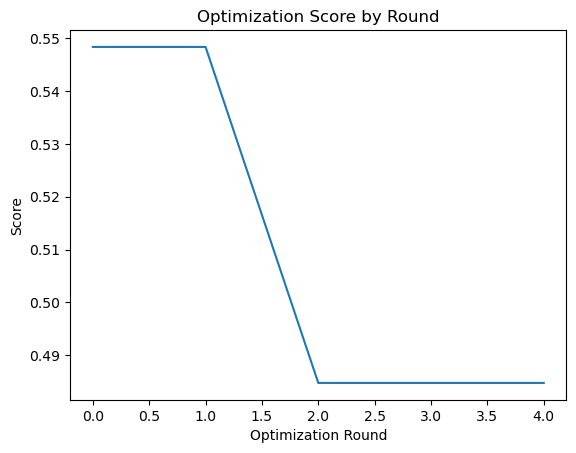

In [223]:
#OPTIMUM VALUE PLOT
allX = []
try:
    X_0 = np.loadtxt(dir_name+'/allXinit.txt')
except: 
    X_0 = np.loadtxt(dir_name+ '/allX0.txt')
allX.append(X_0)
for i in range(1,n_iter):
    print(i)
    X_i = np.loadtxt(dir_name+'/allX{}.txt'.format(i))
    allX.append(X_i)
optimum_value_tuples = []
for i in range(n_iter): 
    roun = i
    optimum = allX[i][0,-1]
    optimum_value_tuples.append((roun, optimum))
print(optimum_value_tuples)
optimum_array = np.array(optimum_value_tuples)
dataset = pd.DataFrame({'Optimization Round': optimum_array[:, 0], 'Score': optimum_array[:, 1]})
sns.lineplot(data = dataset, x = 'Optimization Round', y = 'Score').set_title("Optimization Score by Round")


#FILTER BAD VALUES
#X = X[np.where(X[:,-1] != 1.0)]
#LOAD SURROGATE
filename = dir_name+'/surrogate{}.pkl'.format(final_round)
with open(filename, "rb") as f:
   sm = pickle.load(f)


#PAIRPLOT OF SURROGATE AND REAL DATA


In [224]:

design_space = DesignSpace ([
    IntegerVariable (lowerbounds[0], upperbounds[0]), #Read Length
    FloatVariable (lowerbounds[1], upperbounds[1]), #Coverage
    FloatVariable (lowerbounds[2], upperbounds[2]), #error rate
    IntegerVariable (lowerbounds[3], upperbounds[3]), #number of single cells
    IntegerVariable (lowerbounds[4], upperbounds[4]), #paired or unpaired
    IntegerVariable (lowerbounds[5], upperbounds[5]), #WES OR WGS 0 is wgs 1 is wes
    IntegerVariable(lowerbounds[6], upperbounds[6]) # number of samples
])
random_state = random.randint(1,100)
sampling = MixedIntegerSamplingMethod (LHS , design_space, criterion ="ese", random_state = random_state) #random_state = random_state)
Xtest = sampling(N)
Ytest = sm.predict_values(Xtest)
Yvar = sm.predict_variances(Xtest)
final_surrogate_round = np.hstack((Xtest, Ytest))
final_rounds = allX[-1]
rounds = []
for i in final_rounds:
    for j in range(n_iter):
        if(j == 0):
            try:
                checking_array = np.loadtxt(dir_name+'/allX{}.txt'.format(j))
            except:
                checking_array = np.loadtxt(dir_name+'/allXinit.txt')
        else:
            checking_array = np.loadtxt(dir_name+'/allX{}.txt'.format(j))
        if(np.any(np.all(i == checking_array, axis=1))): 
            rounds.append(j)
            break
print(rounds)
print(len(rounds))
rounds = np.array(rounds)
n_rounds = rounds.shape[0]
rounds = rounds.reshape((n_rounds,1))
print(rounds.shape)
print(final_rounds.shape)
final_rounds = np.column_stack((final_rounds, rounds))

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0489531
   
   Prediction time/pt. (sec) :  0.0000979
   
[2, 3, 4, 2, 2, 2, 0, 1, 0, 1, 2, 4, 2, 2, 3, 2, 2, 0, 2, 1, 2, 1, 3, 3, 4, 1, 2, 2, 3, 3, 2, 1, 3, 1, 0, 3, 0, 1, 4, 4, 0, 3, 3, 0, 1, 3, 0, 4, 4, 1, 4, 1, 4, 4, 4, 2, 0, 0, 3, 0, 3, 0, 4, 4, 1, 0, 2, 4, 1, 4, 0, 1, 1, 0, 4, 2, 3, 0, 0, 3, 0, 3, 2, 3, 1, 4, 1, 0, 4, 3, 0]
91
(91, 1)
(91, 8)


    Read Length   Coverage  Error Rate  N_Single_Cells  Paired  Exome  \
0   4904.000000  44.963912    0.051013             1.0     1.0    0.0   
1   7471.000000  43.861907    0.000000             1.0     1.0    0.0   
2   6023.000000  50.000000    0.079323             1.0     1.0    0.0   
3   6022.999984  20.036094    0.100000             1.0     1.0    0.0   
4   6307.000000  43.861907    0.000000             1.0     1.0    0.0   
..          ...        ...         ...             ...     ...    ...   
86  6001.000000   1.000000    0.021764             1.0     1.0    0.0   
87  9368.000000   1.904474    0.031664             0.0     1.0    0.0   
88  7152.000000   1.000000    0.100000             1.0     1.0    0.0   
89  6307.000000   1.000000    0.000000             1.0     1.0    0.0   
90   199.000000  29.006980    0.021489             0.0     1.0    1.0   

    N_samples     Score  Round  
0         2.0  0.484775      2  
1         2.0  0.492063      3  
2         2.0  0.492222 

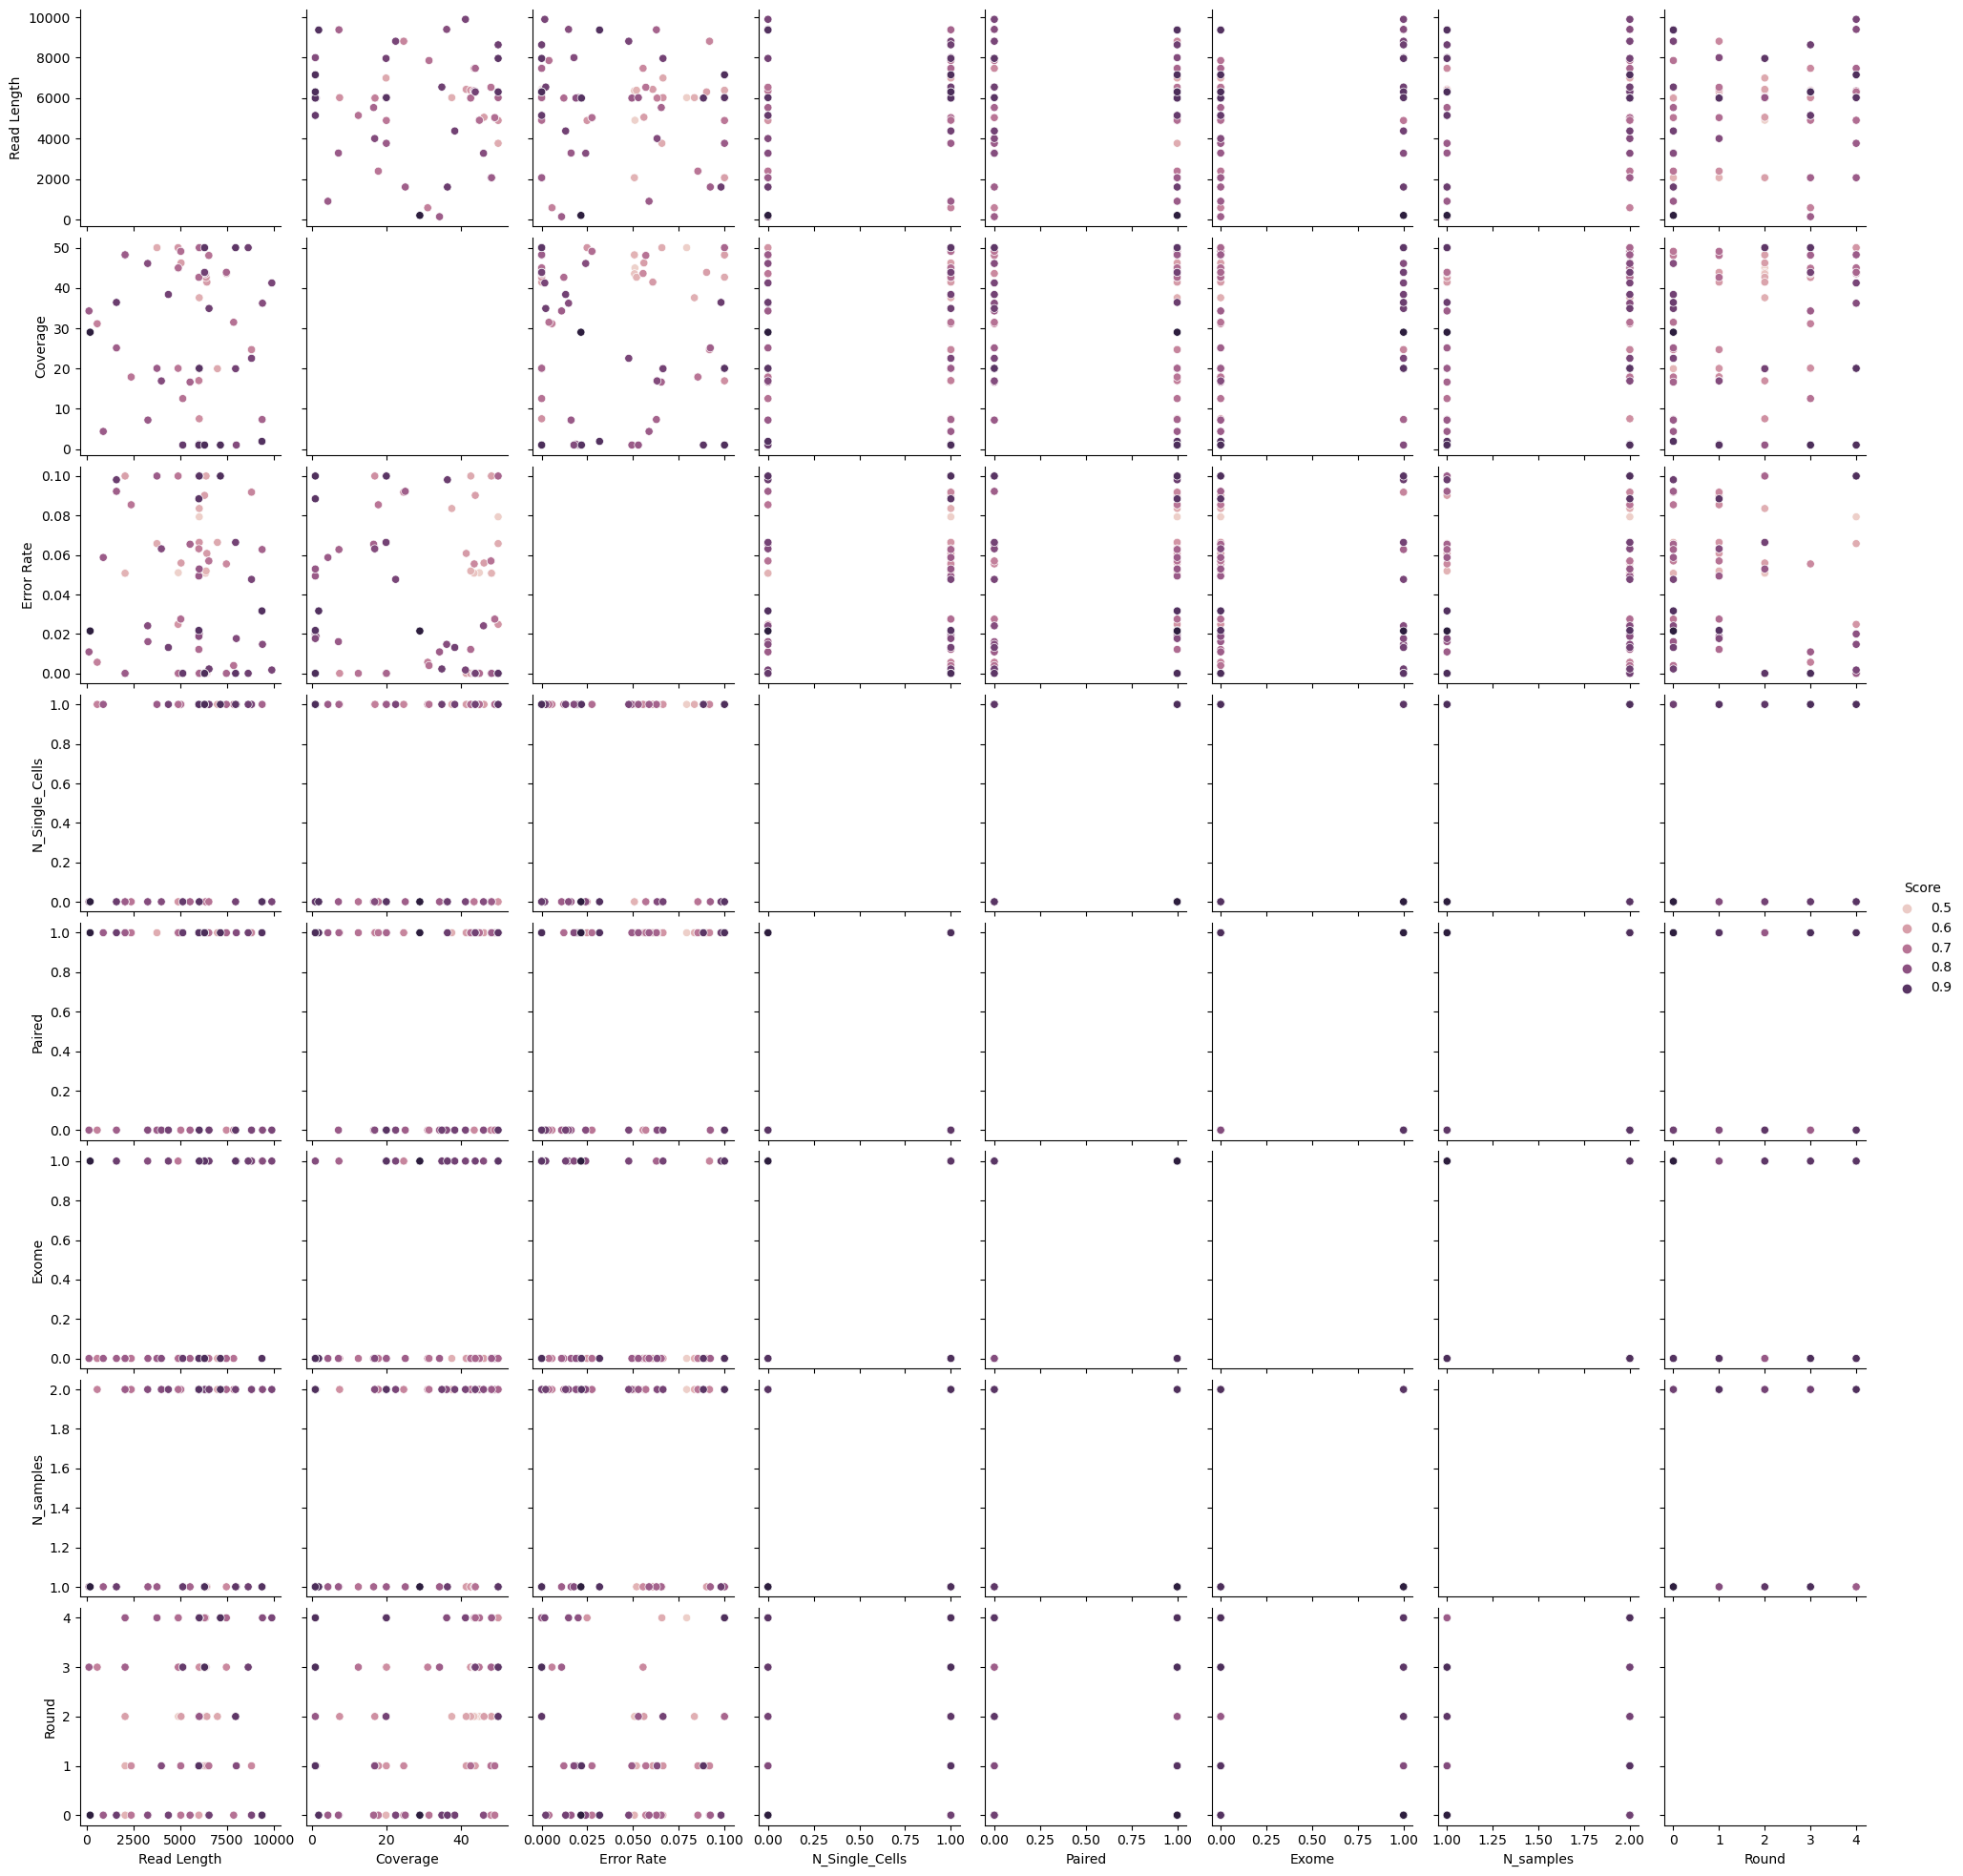

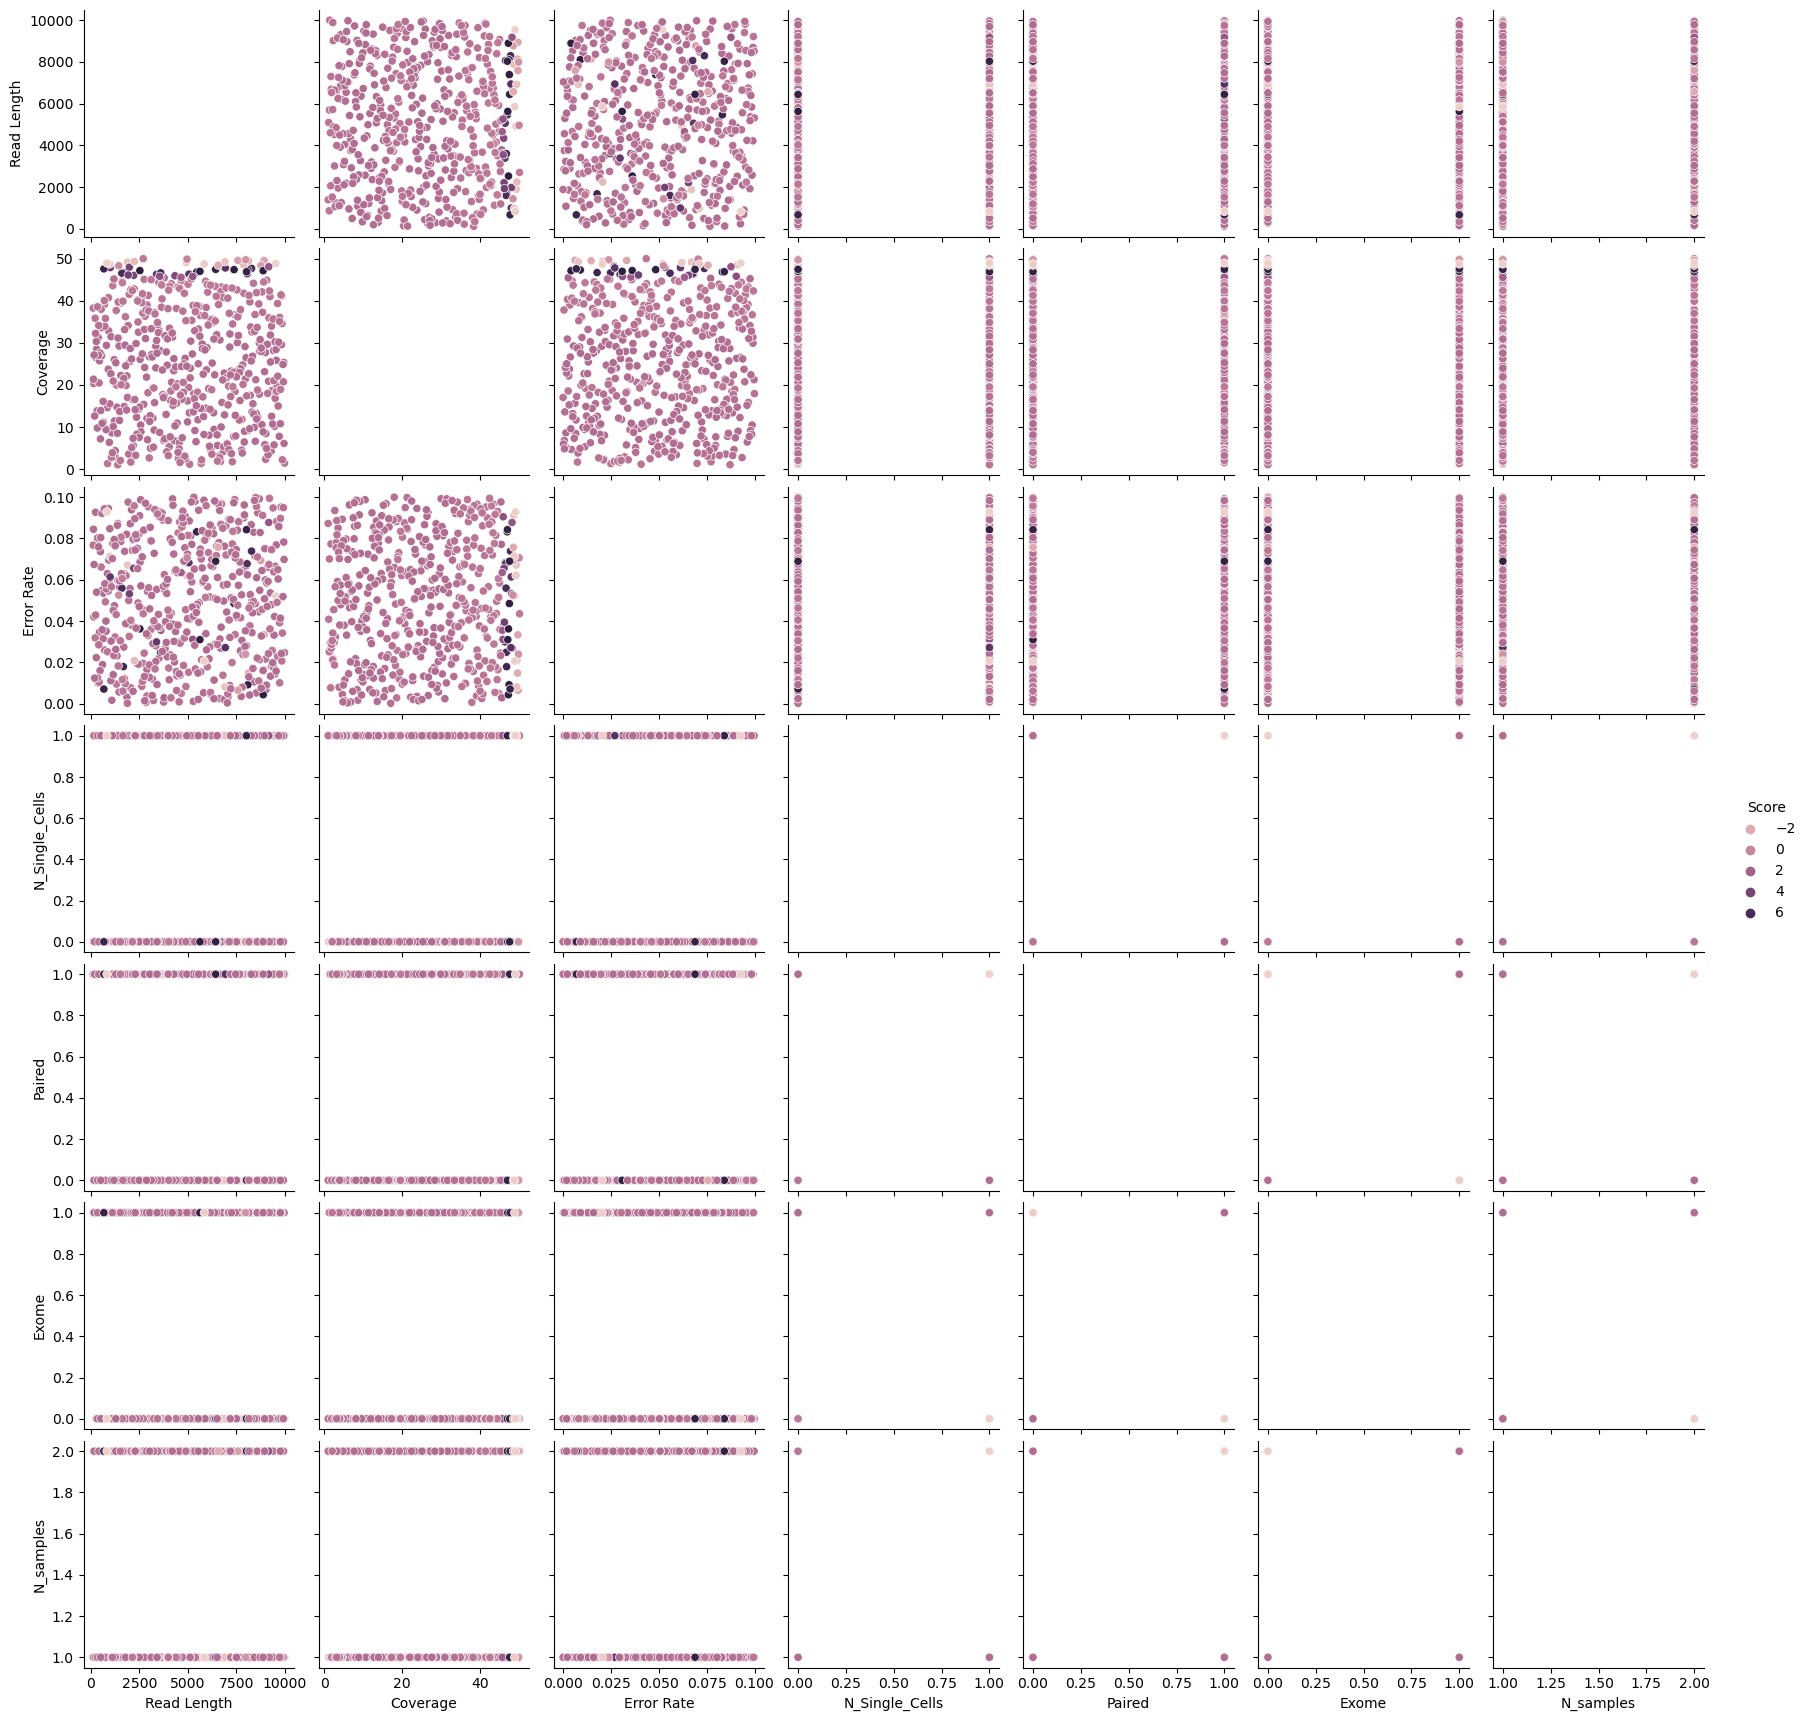

In [225]:


#Throw out outliers 
#final_rounds = final_rounds[:-1, :]

final_dataset = pd.DataFrame({'Read Length':final_rounds[:,0], "Coverage":final_rounds[:,1], "Error Rate":final_rounds[:,2], "N_Single_Cells":final_rounds[:,3],"Paired":final_rounds[:,4], "Exome":final_rounds[:,5], "N_samples":final_rounds[:,6] , "Score":final_rounds[:,7], "Round":final_rounds[:,8]}
                                            )
final_dataset.Paired = final_dataset.Paired.round()
final_dataset.Exome = final_dataset.Exome.round()
final_dataset.N_samples = final_dataset.N_samples.round()
final_dataset.N_Single_Cells = final_dataset.N_Single_Cells.round()
final_dataset['Round'] = final_dataset['Round'].astype('int')
#FILTER OUT NONSENSE VALUES HERE
final_dataset = final_dataset[final_dataset['Score'] != 1.0]
final_dataset = final_dataset[final_dataset['Score'] < 3]
print(final_dataset)

#the_palette = sns.color_palette("bright", n_colors = 3)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap = sns.color_palette(flatui).as_hex()
#PAIRPLOTS FOR SURROGATE AND REAL RESULTS
final_surrogate_dataset = pd.DataFrame({'Read Length':final_surrogate_round[:,0], "Coverage":final_surrogate_round[:,1], "Error Rate":final_surrogate_round[:,2], "N_Single_Cells":final_surrogate_round[:,3],"Paired":final_surrogate_round[:,4], "Exome":final_surrogate_round[:,5], "N_samples":final_surrogate_round[:,6] , "Score":final_surrogate_round[:,7]})
final_surrogate_dataset.Paired = final_surrogate_dataset.Paired.round()
final_surrogate_dataset.Exome = final_surrogate_dataset.Exome.round()
final_surrogate_dataset.N_samples = final_surrogate_dataset.N_samples.round()
final_surrogate_dataset.N_Single_Cells = final_surrogate_dataset.N_Single_Cells.round()
sns.pairplot(final_dataset,hue = "Score")
sns.pairplot(final_surrogate_dataset, hue = 'Score', diag_kind = 'kde')

In [232]:
print(final_surrogate_dataset)

     Read Length   Coverage  Error Rate  N_Single_Cells  Paired  Exome  \
0         7166.0  28.997523    0.008795             1.0     0.0    1.0   
1         9305.0   4.246371    0.047874             0.0     1.0    1.0   
2         6766.0  15.821508    0.096818             0.0     1.0    0.0   
3         8319.0  13.534990    0.050189             1.0     1.0    0.0   
4         1976.0  41.527522    0.032556             1.0     1.0    0.0   
..           ...        ...         ...             ...     ...    ...   
495       7198.0  22.362354    0.089066             1.0     0.0    0.0   
496        505.0  13.894519    0.080416             1.0     0.0    0.0   
497       5541.0  25.012734    0.002008             1.0     0.0    0.0   
498        824.0  48.949697    0.092855             1.0     1.0    0.0   
499       3412.0  27.531982    0.009223             0.0     1.0    1.0   

     N_samples     Score  
0          2.0  1.293228  
1          1.0  1.164512  
2          1.0  1.170517  
3  

    Read Length   Coverage  Error Rate  N_Single_Cells  Paired  Exome  \
0   4904.000000  44.963912    0.051013             1.0     1.0    0.0   
1   7471.000000  43.861907    0.000000             1.0     1.0    0.0   
2   6023.000000  50.000000    0.079323             1.0     1.0    0.0   
3   6022.999984  20.036094    0.100000             1.0     1.0    0.0   
4   6307.000000  43.861907    0.000000             1.0     1.0    0.0   
..          ...        ...         ...             ...     ...    ...   
86  6001.000000   1.000000    0.021764             1.0     1.0    0.0   
87  9368.000000   1.904474    0.031664             0.0     1.0    0.0   
88  7152.000000   1.000000    0.100000             1.0     1.0    0.0   
89  6307.000000   1.000000    0.000000             1.0     1.0    0.0   
90   199.000000  29.006980    0.021489             0.0     1.0    1.0   

    N_samples     Score  Round  
0         2.0  0.484775      2  
1         2.0  0.492063      3  
2         2.0  0.492222 

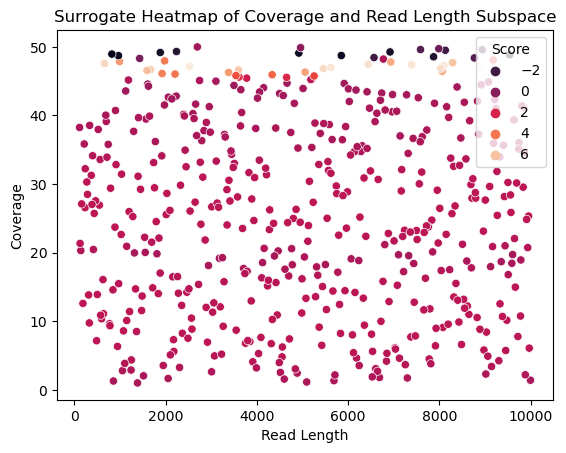

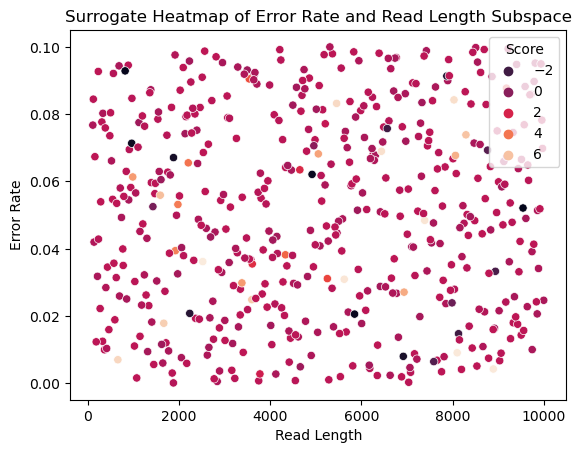

Text(0.5, 1.0, 'Coverage versus Error Rate colored by Score')

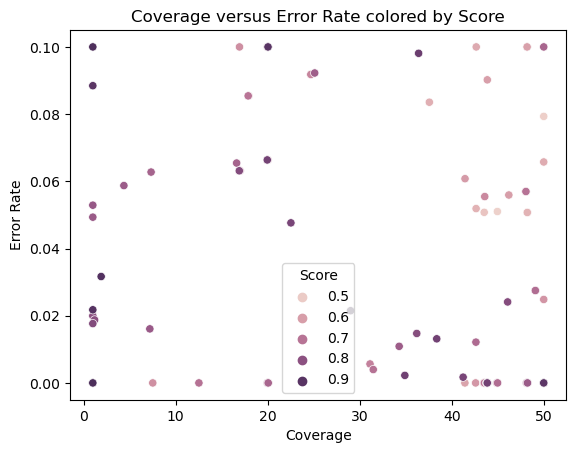

In [226]:
print(final_dataset)
#pick plots you care about here
sns.scatterplot(data = final_surrogate_dataset, x = "Read Length", y = "Coverage", hue = "Score", palette = "rocket").set_title("Surrogate Heatmap of Coverage and Read Length Subspace")
plt.show()
plt.close()
sns.scatterplot(data = final_surrogate_dataset, x = "Read Length", y = "Error Rate", hue = "Score", palette = "rocket").set_title("Surrogate Heatmap of Error Rate and Read Length Subspace")

plt.show()
plt.close()
sns.scatterplot(data = final_dataset, x = "Coverage", y = "Error Rate", hue = "Score").set_title("Coverage versus Error Rate colored by Score")

[-3.79949493] [7.1609922]


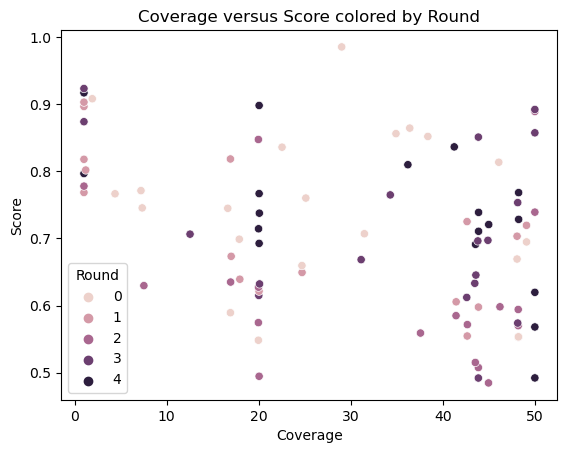

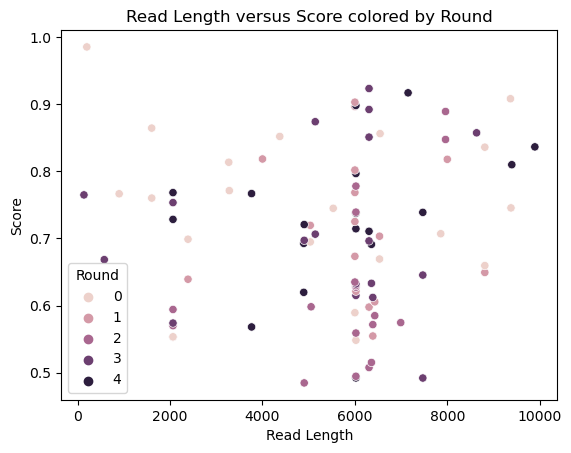

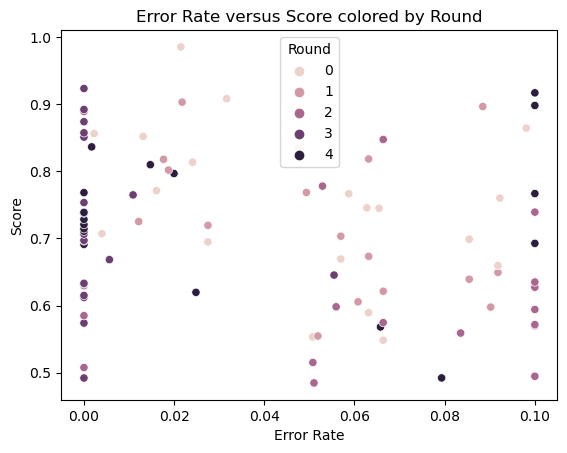

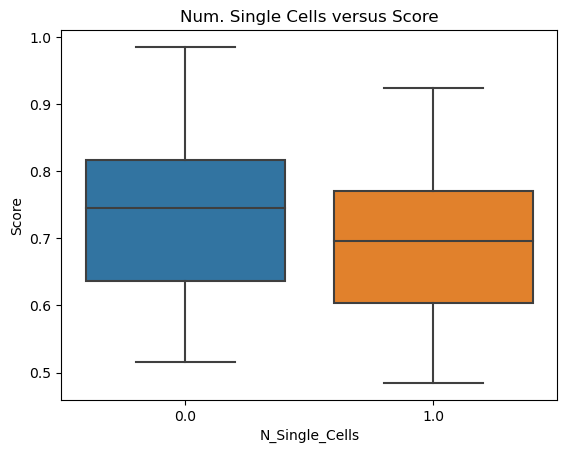

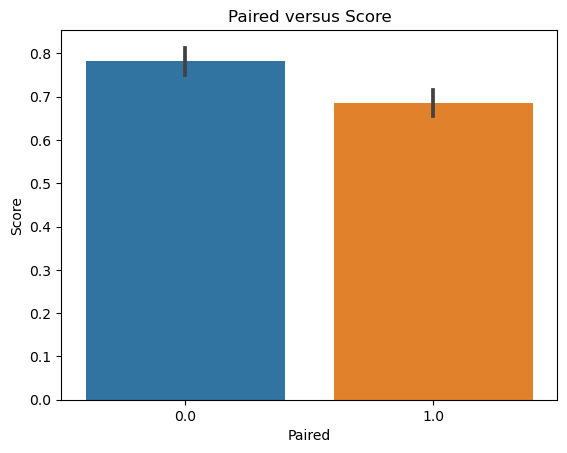

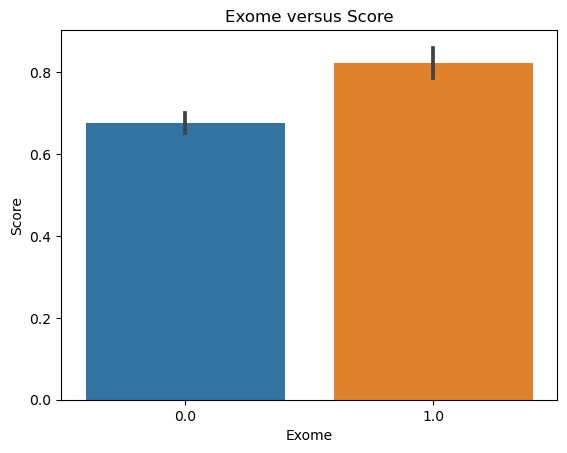

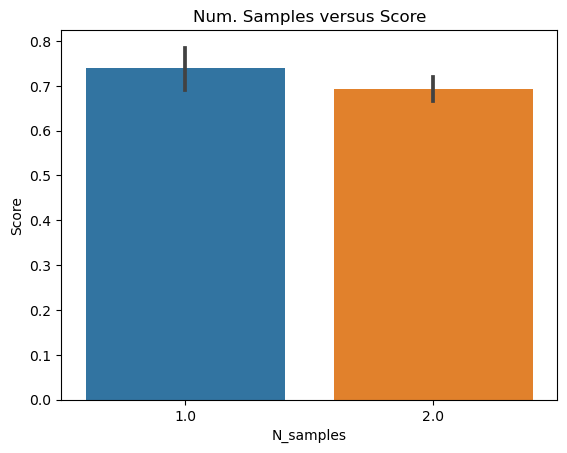

In [227]:
print(min(Ytest), max(Ytest))
sns.scatterplot(data=final_dataset, x="Coverage", y="Score", hue = "Round", legend = 'full').set_title("Coverage versus Score colored by Round")
plt.show()
plt.close()
sns.scatterplot(data=final_dataset, x="Read Length", y="Score", hue = "Round", legend = 'full').set_title("Read Length versus Score colored by Round")
plt.show()
plt.close()
sns.scatterplot(data=final_dataset, x="Error Rate", y="Score", hue = "Round", legend = 'full').set_title("Error Rate versus Score colored by Round")
plt.show()
plt.close()
sns.boxplot(data=final_dataset, x="N_Single_Cells", y="Score").set_title("Num. Single Cells versus Score")
plt.show()
plt.close()
sns.barplot(data=final_dataset, x="Paired", y="Score").set_title("Paired versus Score")
plt.show()
plt.close()
sns.barplot(data=final_dataset, x="Exome", y="Score").set_title("Exome versus Score")
plt.show()
plt.close()
sns.barplot(data=final_dataset, x="N_samples", y="Score").set_title("Num. Samples versus Score")
plt.show()
plt.close()

[0.22181707 0.2053316 ]
[11.88686144 11.43661803]
[[-0.64891886  0.3304258  -0.01297191 -0.63442429 -0.17887152 -0.18403906
   0.03457255]
 [ 0.23512896  0.14058985 -0.19378019 -0.1879688  -0.62324846  0.6574592
  -0.17712874]]
(91, 2) (91, 1)


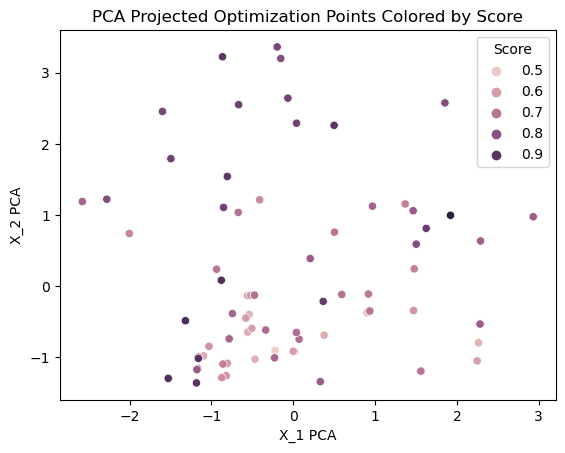

Text(0.5, 1.0, 'PCA Projected Optimization Points Colored by Round')

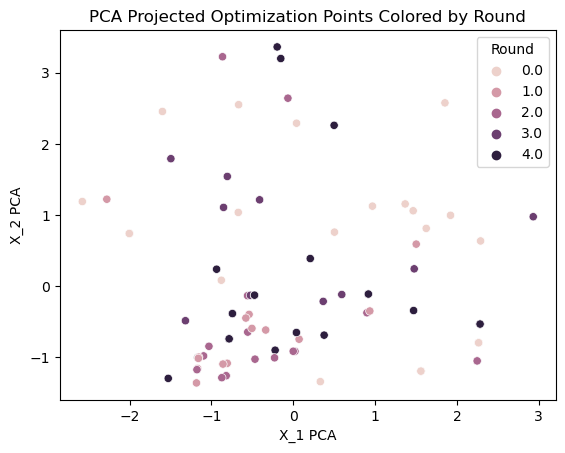

In [228]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca = sklearn.decomposition.PCA(n_components = 2)
#Xpca = allX[-1][:,:-1]
Xpca = final_dataset.to_numpy()[:,:-2]
Xpca = scaler.fit_transform(Xpca)
pca.fit(Xpca)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)
newX = pca.fit_transform(Xpca)
Y = final_dataset.to_numpy()[:,-2]
Round = final_dataset.to_numpy()[:,-1]
Round = np.reshape(Round,(Round.shape[0], 1))

Y = np.reshape(Y,(Y.shape[0], 1))
print(newX.shape, Y.shape)

pca_data = np.hstack((newX, Y))
pca_data = np.hstack((pca_data, Round))
dataset = pd.DataFrame({'X_1 PCA': pca_data[:, 0], 'X_2 PCA': pca_data[:, 1], 'Score': pca_data[:,2], 'Round': pca_data[:,3]})
sns.scatterplot(data = dataset, x = 'X_1 PCA', y = 'X_2 PCA', hue = 'Score').set_title("PCA Projected Optimization Points Colored by Score")
plt.show()
plt.close()

sns.scatterplot(data = dataset, x = 'X_1 PCA', y = 'X_2 PCA', hue = 'Round').set_title("PCA Projected Optimization Points Colored by Round")

(91, 2) (91, 1)
[[-0.10380556  4.88904858  0.48477544  2.        ]
 [-0.64640087  2.31045771  0.49206271  3.        ]
 [-0.46680737  6.10097504  0.49222179  4.        ]
 [-3.913939    7.5351181   0.4946889   2.        ]
 [-2.58248329 -2.84426832  0.50767742  2.        ]
 [ 4.66734028  4.2746582   0.51523466  2.        ]
 [-3.83743787  6.25042486  0.54833471  0.        ]
 [ 6.91644144  5.71126652  0.55312294  1.        ]
 [ 6.68899345  5.38823843  0.55343395  0.        ]
 [-1.2372613  -1.69670558  0.55462493  1.        ]
 [-1.57249606  6.40197277  0.55903234  2.        ]
 [-0.37291127 -1.88018084  0.56808791  4.        ]
 [ 7.82934189  4.95047283  0.57002097  2.        ]
 [-0.26487377 -0.82473439  0.57160804  2.        ]
 [ 6.20832682  6.72804642  0.57387978  3.        ]
 [-3.29031873  6.31406975  0.57457415  2.        ]
 [-2.85352731 -1.95366943  0.58492206  2.        ]
 [-3.98532915  5.48081446  0.58932153  0.        ]
 [ 7.82583761  4.9471488   0.59411774  2.        ]
 [-0.35662428 -

Text(0.5, 1.0, 'tSNE Optimization Points Colored by Score')

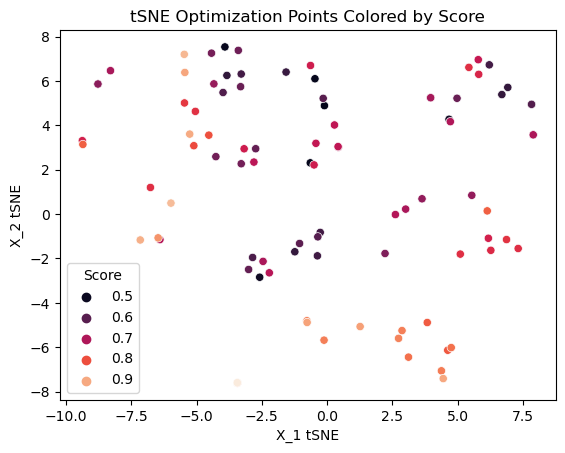

In [229]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
#Xfin, Y = allX[-1][:,:-1], allX[-1][:,-1]
Xfin, Y = final_dataset.to_numpy()[:, :-2], final_dataset.to_numpy()[:,-2]
Xfin = scaler.fit_transform(Xfin)
#Xfin, Y = Xtest, Ytest
newX = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=20).fit_transform(Xfin)
rounds = final_dataset.to_numpy()[:,-1]
Y = np.reshape(Y,(Y.shape[0], 1))
rounds = np.reshape(rounds, (rounds.shape[0],1))
print(newX.shape, Y.shape)
tsne_data = np.hstack((newX, Y))
tsne_data = np.hstack((tsne_data, rounds))
print(tsne_data)
dataset = pd.DataFrame({'X_1 tSNE': tsne_data[:, 0], 'X_2 tSNE': tsne_data[:, 1], 'Score': tsne_data[:,2], 'Round': tsne_data[:,3]})
dataset['Round'] = dataset['Round'].astype('int')
sns.scatterplot(data = dataset, x = 'X_1 tSNE', y = 'X_2 tSNE', hue = 'Score', palette = 'rocket').set_title('tSNE Optimization Points Colored by Score')

Text(0.5, 1.0, 'tSNE Optimization Points Colored by Round Produced')

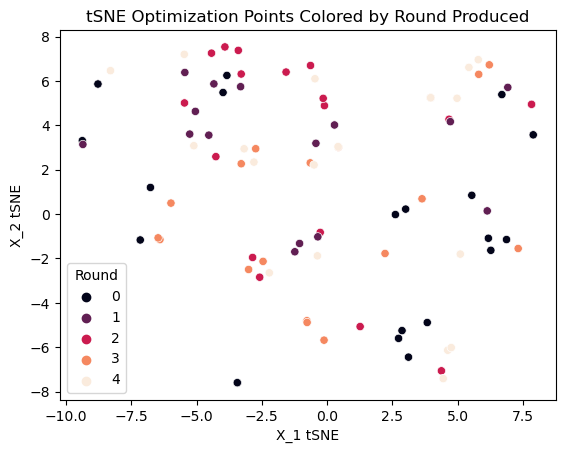

In [230]:
# POINTS EXPLORED FROM ONE ROUND TO THE NEXT PLOT
sns.scatterplot(data= dataset, x = 'X_1 tSNE', y = 'X_2 tSNE', hue = 'Round', legend = 'full', palette = 'rocket').set_title("tSNE Optimization Points Colored by Round Produced")

Text(0.5, 1.0, 'Optimization Scores by Round')

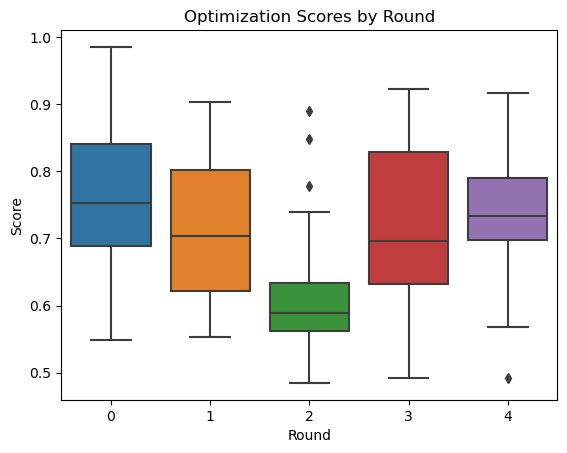

In [231]:
sns.boxplot(data = final_dataset, x = 'Round', y = 'Score').set_title('Optimization Scores by Round')